In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import random
from rdflib import Graph, URIRef
from rdflib.namespace import RDF, RDFS, SOSA
from standard_api.api_handler import ApiRequester
import timeit
import uuid

from viscars.namespace import DASHB
from viscars.recommenders.factory import RecommenderFactory, RecommenderType

In [2]:
PROJECT = 'proeftuin'
REASONER_API_ENDPOINT = 'https://reasoner.dynamicdashboard.ilabt.imec.be/api/v1/reasoner'
REASONER_METADATA_DATABASE = 'proeftuin_metadata_prod'

TEMPLATES = {
    'DASHBOARD': 'https://dynamicdashboard.ilabt.imec.be/dashboards/{uuid}',
    'TAB': 'https://dynamicdashboard.ilabt.imec.be/tabs/{uuid}',
    'WIDGET': 'https://dynamicdashboard.ilabt.imec.be/widgets/{uuid}',
    'USER': 'https://dynamicdashboard.ilabt.imec.be/users/{uuid}'
}

In [3]:
recommenders = [r for r in RecommenderType]
recommenders.remove(RecommenderType.RANDOM)
recommenders.remove(RecommenderType.PAGERANK)


In [4]:
graph = Graph()
graph.parse(f'./data/{PROJECT}/metadata.ttl', format='n3')
graph.parse(f'./data/{PROJECT}/metrics.ttl', format='n3')
graph.parse(f'./data/{PROJECT}/sensors.ttl', format='n3')
graph.parse(f'./data/{PROJECT}/visualizations.ttl', format='n3')

metadata_nodes = len(graph.all_nodes())

In [5]:
# TODO: Figure out why `graph.subjects` doesn't work..
properties = [s[0] for s in graph.triples((None, RDF.type, SOSA.ObservableProperty))]

In [6]:
def get_valid_visualizations(properties_: [], aggregation=None, from_=None, to=None):
    metadata = {
        'metadataDatabase': f'{REASONER_METADATA_DATABASE}',
        'eventsDatabase': 'string'
    }
    data = {
        'propertyIds': properties_,
        'aggregationId': aggregation,
        'from': from_,
        'to': to
    }

    requester = ApiRequester(REASONER_API_ENDPOINT)
    result = requester.call('/property_visualizations', data=data, metadata=metadata)

    return [visualization['visualizationId'] for visualization in result]

valid_visualizations = {}

for property_ in properties:
    # Get rid of AAA BIM heatmaps..
    valid_visualizations[property_] = [v for v in get_valid_visualizations([str(property_)]) if 'heatmap' not in v]

In [7]:
user_groups = [s[0] for s in graph.triples((None, RDF.type, DASHB.UserGroup))]
users = []

def create_dashboards(n=1):
    for _ in range(n):
        dashboard = URIRef(TEMPLATES['DASHBOARD'].format(uuid=uuid.uuid4()))
        tab = URIRef(TEMPLATES['TAB'].format(uuid=uuid.uuid4()))
        widget = URIRef(TEMPLATES['WIDGET'].format(uuid=uuid.uuid4()))
        user = URIRef(TEMPLATES['USER'].format(uuid=uuid.uuid4()))
        users.append(user)

        user_group = random.choice(user_groups)
        random_property = random.choice(properties)
        visualization = URIRef(random.choice(valid_visualizations[random_property]))

        graph.add((dashboard, RDF.type, DASHB.Dashboard))

        graph.add((tab, RDF.type, DASHB.Tab))
        graph.add((dashboard, DASHB.hasTab, tab))

        graph.add((widget, RDF.type, DASHB.Widget))
        graph.add((tab, DASHB.hasWidget, widget))

        graph.add((user, RDF.type, DASHB.User))
        graph.add((user, DASHB.memberOf, user_group))
        graph.add((widget, DASHB.createdBy, user))

        graph.add((widget, DASHB.hasProperty, random_property))
        graph.add((widget, DASHB.visualizedBy, visualization))

In [8]:
result = pd.DataFrame(columns=['nodes', 'edges'].extend([r.value for r in recommenders]))

n_runs = 5

while len(list(graph.triples((None, None, None)))) < 200000:

    create_dashboards(1000)
    data = {'nodes': len(graph.all_nodes()), 'edges': len(list(graph.triples((None, None, None))))}
    for recommender in recommenders:

        r = RecommenderFactory().get(recommender)(graph)
        r.set_personalization(0.7, 0.3)

        timing = timeit.timeit(lambda: r.predict(random.choice(users), random.choice(properties)), number=n_runs) / n_runs
        data[recommender.value] = timing

    print(data)
    result = result.append(data, ignore_index=True)

print(result.head())

{'nodes': 4364, 'edges': 10875, 'ppr': 0.05112614000000093, 'fast_ppr': 0.0351900999999998}
{'nodes': 8364, 'edges': 20875, 'ppr': 0.09955488000000087, 'fast_ppr': 0.06794797999999957}
{'nodes': 12364, 'edges': 30875, 'ppr': 0.1501385799999994, 'fast_ppr': 0.12347635999999937}
{'nodes': 16364, 'edges': 40875, 'ppr': 0.20312894000000056, 'fast_ppr': 0.15800796000000047}
{'nodes': 20364, 'edges': 50875, 'ppr': 0.25222358000000045, 'fast_ppr': 0.19180109999999928}
{'nodes': 24364, 'edges': 60875, 'ppr': 0.3050244599999985, 'fast_ppr': 0.2265163799999982}
{'nodes': 28364, 'edges': 70875, 'ppr': 0.35655326000000115, 'fast_ppr': 0.25996948000000086}
{'nodes': 32364, 'edges': 80875, 'ppr': 0.40942018000000074, 'fast_ppr': 0.29906578000000084}
{'nodes': 36364, 'edges': 90875, 'ppr': 0.47664576000000236, 'fast_ppr': 0.33000590000000046}
{'nodes': 40364, 'edges': 100875, 'ppr': 0.5242720999999989, 'fast_ppr': 0.36363489999999954}
{'nodes': 44364, 'edges': 110875, 'ppr': 0.5976013199999983, 'fast

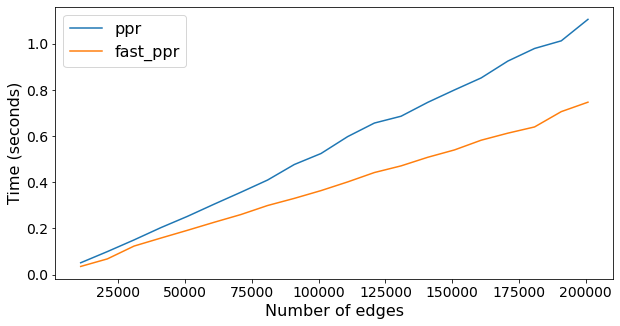

In [26]:
fig = plt.figure(figsize=(10, 5))

for recommender in recommenders:
    plt.plot(result['edges'], result[recommender.value], label=recommender.value)

plt.xlabel('Number of edges', fontsize=16)
plt.ylabel('Time (seconds)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=16)
plt.savefig('scalability.png', dpi=600)
plt.show()

In [ ]:
print(len(list(graph.triples((None, RDF.type, DASHB.User)))))
print(len(list(graph.triples((None, RDF.type, DASHB.Dashboard)))))